# Graph Layout
In this exercise you'll write code to automatically layout a graph given only its edges.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as lines
%matplotlib inline

In [2]:
import numpy as np
from dv_utils import test_case_checker

## Part 1: Representing and Plotting a Graph

First we'll look at a simple six node graph with positions defined for each of the nodes in an x and y array.

In [3]:
x = np.array([0,0,1,0.5,1,1])

In [4]:
y = np.array([0,1,1,0,0,0.5])

In [5]:
print(x,y)

[0.  0.  1.  0.5 1.  1. ] [0.  1.  1.  0.  0.  0.5]


Then we'll define the graph as a list of eight edges. Each edge is of the form [i,j] indicates an edge between node i and node j. We don't need to explicitly define the nodes, we just assume the nodes are numbered from zero to the largest node referenced in the edge list. This is an undirected graph, so if [i,j] is in the edge list, [j,i] should not be in the edge list. We also don't assume any order, so either [i,j] or [j,i] can be used, and the edges can appear in any order in the list.

In [6]:
edges = np.array([[0,1],[0,3],[1,2],[1,4],[2,5],[3,4],[3,5],[4,5]])

In [7]:
print(edges)

[[0 1]
 [0 3]
 [1 2]
 [1 4]
 [2 5]
 [3 4]
 [3 5]
 [4 5]]


The code below defines the procedure `graphplot(x,y,edges)`, which plots the graph by placing nodes at the positions using the `x` any `y` arrays for coordinates, and `edges` for the lines connecting these node positions. It does this by first plotting `x` and `y` as a scatterplot, using disks of area 500pts with a white fill and black stroke. It then annotating this scatterplot with the node indices. Once the nodes are plotted, the procedure cycles through `edges` and plots each edge `e` as a line in the scatterplot coordinate system to indicate a connection between the nodes, using the style string `'k-'` to indicate the solid lines (`-`) are black (`k`).

In [8]:
def graphplot(x,y,edges):
    # Display nodes as white disks with black borders with an area of 500 pts
    plt.scatter(x,y,
                c='white',edgecolors='black',
                s = 500,zorder = 1)

    # Label nodes by their index
    for i in range(len(x)):
        plt.annotate(i,[x[i],y[i]],zorder=2,ha='center',va='center')

    # Display edges by plotting lines
    for e in edges:
        i = e[0]
        j = e[1]
        plt.plot([x[i],x[j]],[y[i],y[j]],'k-',zorder = 0)

    plt.show()

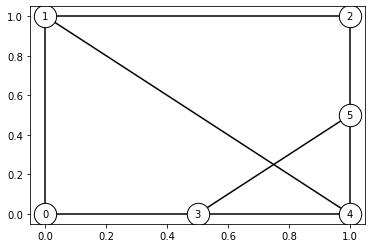

In [9]:
graphplot(x,y,edges)

## Part 2: Solving a Laplacian to Layout a Planar Graph

Now we can make a Laplacian matrix L for this graph. The (normalized) Laplacian matrix for a graph of n nodes is an n x n square identity matrix, with additional entries such that the entry at L[j,i] (row i, column j) is equal to -1/deg(i), where deg(i) is the degree (# of edges) of node i. Thus each row sums to zero.

The Laplacian for our graph is shown below.

In [10]:
L = np.array([[1,-0.5,0,-.5,0,0],
              [-0.333,1,-0.333,0,-0.333,0],
              [0,-.5,1,0,0,-0.5],
              [-0.333,0,0,1,-0.333,-0.333],
              [0,-0.333,0,-.333,1,-0.333],
              [0,0,-0.333,-0.333,-0.333,1]])

In [11]:
L

array([[ 1.   , -0.5  ,  0.   , -0.5  ,  0.   ,  0.   ],
       [-0.333,  1.   , -0.333,  0.   , -0.333,  0.   ],
       [ 0.   , -0.5  ,  1.   ,  0.   ,  0.   , -0.5  ],
       [-0.333,  0.   ,  0.   ,  1.   , -0.333, -0.333],
       [ 0.   , -0.333,  0.   , -0.333,  1.   , -0.333],
       [ 0.   ,  0.   , -0.333, -0.333, -0.333,  1.   ]])

Look what happens when you multiple the Laplacian matrix by one of our coordinates lists. The product Lx is

$$
L x = \left[ \begin{array}{cccccc}
1 & -1/2 & 0 & -1/2 & 0 & 0 \\
-1/3 & 1 & -1/3 & 0 & -1/3 & 0 \\
0 & -1/2 & 1 & 0 & 0 & -1/2 \\
-1/3 & 0 & 0 & 1 & -1/3 & -1/3 \\
0 & -1/3 & 0 & -1/3 & 1 & -1/3 \\
0 & 0 & -1/3 & -1/3 & -1/3 & 1
\end{array} \right] \left[ \begin{array}{c}
x_0 \\ x_1 \\ x_2 \\ x_3 \\ x_4 \\ x_5
\end{array} \right] = 
\left[ \begin{array}{l}
x_0 - \frac{1}{2}(x_1 + x_3) \\
x_1 - \frac{1}{3}(x_0 + x_2 + x_4) \\
x_2 - \frac{1}{2}(x_1 + x_5) \\
x_3 - \frac{1}{3}(x_0 + x_4 + x_5) \\
x_4 - \frac{1}{3}(x_1 + x_3 + x_5) \\
x_5 - \frac{1}{3}(x_2 + x_3 + x_4)
\end{array} \right]
$$

such that the result is the original $x$ with the average of its neighboring node positions subtracted.

We can use this property to reposition each node to a new position that is the average of its neighboring positions. However, this can result in all nodes sharing one single same position which would not be useful. So we need to *pin* some nodes to fixed positions, and let the rest reposition themselves to these average positions.

We'll pick nodes 0, 1 and 2, and replace their rows in the Laplacian with their corresponding rows in an ordinary identity matrix.

In [12]:
L[0] = np.array([1,0,0,0,0,0])
L[1] = np.array([0,1,0,0,0,0])
L[2] = np.array([0,0,1,0,0,0])

In [13]:
L

array([[ 1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ],
       [-0.333,  0.   ,  0.   ,  1.   , -0.333, -0.333],
       [ 0.   , -0.333,  0.   , -0.333,  1.   , -0.333],
       [ 0.   ,  0.   , -0.333, -0.333, -0.333,  1.   ]])

We'll find new position arrays x and y by solving a linear system using this modified Laplacian L. These linear systems will be of the form Lx = b and Ly = c. In order to solve for x and y, we have to define b and c as follows.

In [14]:
b = np.array([0,0,1,0,0,0])

In [15]:
c = np.array([0,1,1,0,0,0])

Now Lx = b looks like this:

$$L x = \left[ \begin{array}{cccccc}
1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
-1/3 & 0 & 0 & 1 & -1/3 & -1/3 \\
0 & -1/3 & 0 & -1/3 & 1 & -1/3 \\
0 & 0 & -1/3 & -1/3 & -1/3 & 1
\end{array} \right] \left[ \begin{array}{c}
x_0 \\ x_1 \\ x_2 \\ x_3 \\ x_4 \\ x_5
\end{array} \right] =
\left[ \begin{array}{l}
0 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0
\end{array} \right]$$

which is essentially the system of equations

$$\begin{array}{l}
x_0 = 0 \\
x_1 = 0 \\
x_2 = 1 \\
x_3 = x_3 - \frac{1}{3}(x_0 + x_4 + x_5) \\
x_4 = x_4 - \frac{1}{3}(x_1 + x_3 + x_5) \\
x_5 = x_5 - \frac{1}{3}(x_2 + x_3 + x_4)
\end{array}$$

and similarly for $Ly = c$.

Thus nodes 0, 1 and 2 are repositioned to fixed positions, and nodes 3, 4 and 5 are moved toward positions that are the averages of their neighboring positions.

We can use this revised Laplacian matrix $L$ that pins the first nodes to the first three coordinates in the $b$-array and $c$-array to solve for the coordinates of the remaining nodes in the $x$-array and $y$-array by solving the system $Lx = b$ for the x coordinates and $Ly = c$ for the $y$ coordinates. This gives us a planar layout of the nodes, with no edge crossings, if one exists.

In [16]:
x = np.linalg.solve(L,b)

In [17]:
print(x)

[0.         0.         1.         0.24906451 0.24906451 0.49887696]


In [18]:
y = np.linalg.solve(L,c)

In [19]:
print(y)

[0.         1.         1.         0.49812902 0.74794148 0.74794148]


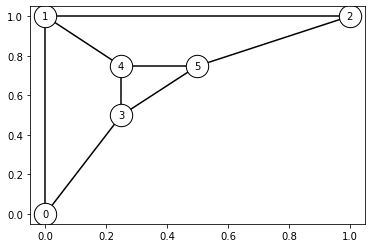

In [20]:
graphplot(x,y,edges)

## Part 3: Writing Code
Now let's write some code. First let's create a new graph to work with.

In [21]:
x = np.array([0,0,1,1,0.5,1])
y = np.array([0,1,1,0,1,0.5])

In [22]:
edges = np.array([[0,1],[0,2],[0,3],[0,4],[0,5],[1,3],[1,4],[2,4],[2,5],[3,4]])

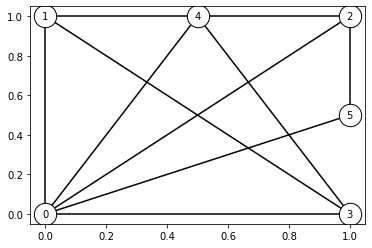

In [23]:
graphplot(x,y,edges)

When we create a Laplacian, we'll need to know the degree of each node. Below create a function `deg(i,edges)` that returns the degree of the node with index `i` of the graph described by `edges` which is a list of edges, with each edge denoted by a pair of node indices. Each edge appears only once, and each edge connects one node to a different node.

In [24]:
def deg(i,edges):
    # your code here
    #raise NotImplementedError
    
    # easy, logical way to loop through the edges
    #count = 0
    #for edge in edges:
    #    if edge[0] == i or edge[1] == i:
    #        count += 1
    #return count

    # fancy, brain tweaking way using numpy
    mask = (edges[:, 0] == i) | (edges[:, 1] == i)
    return np.sum(mask)

In [25]:
# The following cell contains the tests for Part 3, the deg Function.
# You do not need to execute this cell or modify it.


In [26]:
assert(deg(0,edges) == 5)
assert(deg(1,edges) == 3)
assert(deg(2,edges) == 3)
assert(deg(3,edges) == 3)
assert(deg(4,edges) == 4)
assert(deg(5,edges) == 2)

# Checking against the pre-computed test database
test_results = test_case_checker(deg, task_id='part3_deg')
assert test_results['passed'], test_results['message']

Now we can write a function `lap(edges)` to compute the Laplacian matrix of the graph specified by `edges`. We can assume the graph is connected and there are no isolated edges, so all of the node indices appear at least once in the edge list and there are no indices missing between zero and the highest node index.

In [27]:
def lap(edges):
    # your code here
    #raise NotImplementedError
    
   # the maximum node index
    n = edges.max() + 1
    
    # degree of each node
    degree = np.array([deg(i, edges) for i in range(n)])
    
    # the Laplacian matrix
    L = np.zeros((n,n))
        
    # fill the Laplacian matrix
    for edge in edges:
        i, j = edge
        L[i, j] = -1 / degree[i]
        L[j, i] = -1 / degree[j]
    
    # fill the diagonal elements with degrees
    np.fill_diagonal(L, 1)
    for i in range(n):
        L[i, i] = 1
        
    return L

In [28]:
# The following cells contains the tests for Part (3), the lap Function.
# You do not need to execute this cell or modify it.


In [29]:
L = lap(edges)

assert(all(np.round(L[0],3) == np.array([1,-.2,-.2,-.2,-.2,-.2])))
assert(all(np.round(L[1],3) == np.array([-0.333,1,0,-0.333,-.333,0])))
assert(all(np.round(L[2],3) == np.array([-0.333,0,1,0,-0.333,-.333])))
assert(all(np.round(L[3],3) == np.array([-0.333,-0.333,0,1,-.333,0])))
assert(all(np.round(L[4],3) == np.array([-0.25,-0.25,-0.25,-0.25,1,0])))
assert(all(np.round(L[5],3) == np.array([-0.5,0,-0.5,0,0,1])))

# Checking against the pre-computed test database
test_results = test_case_checker(lap, task_id='part3_lap')
assert test_results['passed'], test_results['message']

## Part 4: Layout the Graph
Now you can use your Laplacian matrix to layout the graph so it is planar and doesn't have any edge crossings so it is easier to visualize.

Pin nodes 0, 1 and 2 to the positions we used for them above, specifically (0,0), (0,1) and (1,1), and solve the Laplacian systems to find the coordinates of nodes 3, 4 and 5.

You should compute the `x` and `y` variables correctly in the next cell.

In [30]:
# your code here
#raise NotImplementedError

# define the positions and edges of the graph
initial_positions = np.array([
    [0, 0],  # Node 0
    [0, 1],  # Node 1
    [1, 1]   # Node 2
])

x_fixed = initial_positions[:, 0]
y_fixed = initial_positions[:, 1]
num_fixed = len(initial_positions)

# pin nodes 0, 1, and 2 to their initial positions
pinned_nodes = np.array([0, 1, 2])
L = lap(edges)

for i in pinned_nodes:
    L[i, :] = 0
    L[i, i] = 1
    
# define b and c vectors for the fixed positions
b = np.zeros(L.shape[0])
c = np.zeros(L.shape[0])
b[pinned_nodes] = x_fixed
c[pinned_nodes] = y_fixed 

# solve the Laplacian systems
x = np.linalg.solve(L, b)
y = np.linalg.solve(L, c)

#print(f"New x positions: {x}")
#print(f"New y positions: {y}")

In [31]:
# The following cell contains the tests for Part (4), the Layout.
# You do not need to execute this cell or modify it.


In [32]:
assert(all(np.round(L[0],3) == np.array([1,0,0,0,0,0])))
assert(all(np.round(L[4],3) == np.array([-.25,-.25,-.25,-.25,1,0])))
assert(np.round(x[3],3) == 0.091)
assert(np.round(y[4],3) == 0.636)

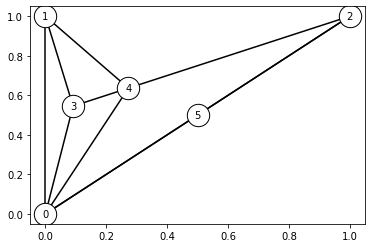

In [33]:
graphplot(x,y,edges)